# Setup

set working directory to guitarist-net and add to path

In [1]:
%cd /content/drive/Othercomputers/My MacBook Pro/guitarist-net

/content/drive/Othercomputers/My MacBook Pro/guitarist-net


install requirements

In [2]:
!pip install -r requirements.txt &> /dev/null

imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from plot_listen.listen import play
from plot_listen.plot import plot
import librosa.display
from globals import *
from ddsp.filtered_noise import FilteredNoise

# Test filtered noise module

In [4]:
fnoise = FilteredNoise()

create dummy input: first half low pass, then high pass

In [41]:
z = {}
low_pass = torch.cat((torch.ones((32, 500, 18)), torch.zeros((32, 500, 110))), dim=-1)
high_pass = torch.cat((torch.zeros((32, 500, 110)), torch.ones((32, 500, 18))), dim=-1)
z['H'] = torch.cat((low_pass, high_pass), dim=1)

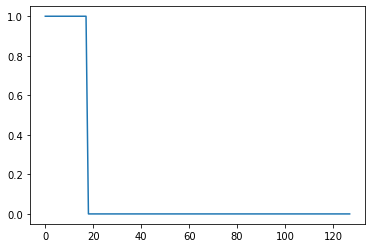

In [42]:
plot(low_pass[0,0])

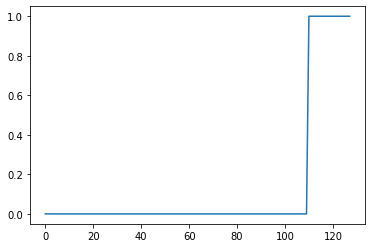

In [43]:
plot(high_pass[0,0])

In [44]:
output = fnoise(z)

In [45]:
print(output.shape)

torch.Size([32, 64000])


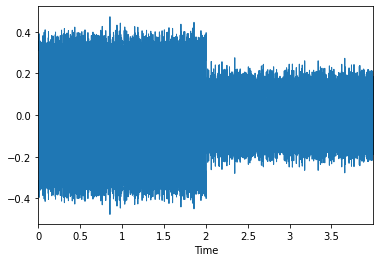

In [46]:
librosa.display.waveplot(output[0].numpy(), sr=SR)

In [47]:
play(output[0])

# Walk through filtered noise code from acics ircam

In [12]:
coeff_len = 4

H = torch.ones((32, 1000, coeff_len)) # (batch, frames, filter_len)
# H[0,0] = np.e ** (-2 * torch.linspace(0,1,coeff_len))
H[0,0] = torch.cat((torch.ones((coeff_len//2)), torch.zeros((coeff_len//2))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

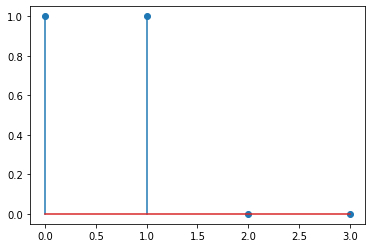

In [13]:
plt.stem(H[0,0].numpy())

add zeros to be complex part

In [14]:
H_complex = torch.stack([H, torch.zeros_like(H)], -1)
H_complex = torch.view_as_complex(H_complex)
print(H_complex.dtype)
print(H_complex.shape)

torch.complex64
torch.Size([32, 1000, 4])


compute irfft

In [15]:
h = torch.fft.irfft(H_complex, n=coeff_len * 2 - 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

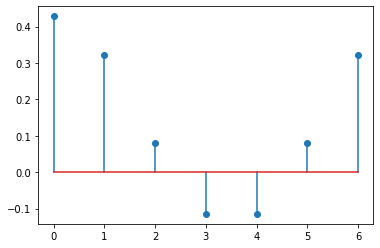

In [16]:
plt.stem(h[0,0])

In [17]:
print(h.shape)

torch.Size([32, 1000, 7])


In [18]:
filter_size = h.shape[-1]

torch roll is like a circular shift

In [19]:
h = torch.roll(h, filter_size // 2, -1) # roll the filter by half the size so that the middle is at the center?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

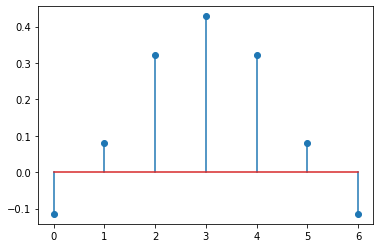

In [20]:
plt.stem(h[0,0])

In [21]:
print(h[0,0,filter_size//2])

tensor(0.4286)


In [22]:
win = torch.hann_window(filter_size)
print(win.shape)

torch.Size([7])


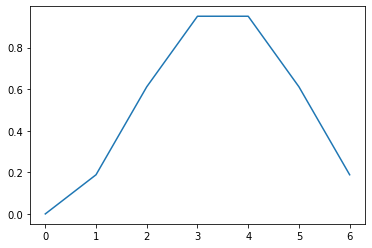

In [23]:
plot(win)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

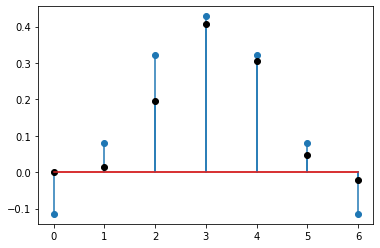

In [24]:
windowed_h = h * win
plt.stem(h[0,0])
plt.stem(windowed_h[0,0], markerfmt="ko")

In [25]:
amp = nn.functional.pad(windowed_h, (0, 20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

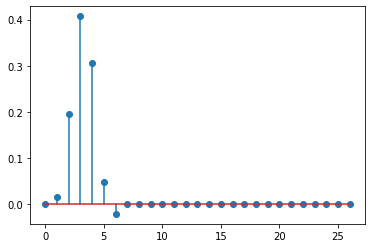

In [26]:
plt.stem(amp[0,0])

In [27]:
amp = torch.roll(amp, -filter_size // 2, -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

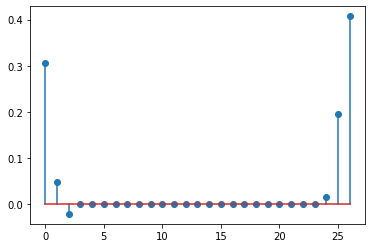

In [28]:
plt.stem(amp[0,0])

In [29]:
2 ** ((512 - 1).bit_length())

512

In [30]:
2**(1023 - 1).bit_length()

1024

# Test overlap add

In [31]:
import torch.nn.functional as F

In [32]:
dummy_arr = torch.ones((32, 3, 6)) # (batch, frames, frame_len)
hop = 5

In [33]:
overlap_add_filter = torch.eye(6)[:, None, :]

In [34]:
print(overlap_add_filter.shape)

torch.Size([6, 1, 6])


In [35]:
print(overlap_add_filter)

tensor([[[1., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 1.]]])


In [36]:
dummy_arr = dummy_arr.transpose(1,2) 

In [37]:
output_signal = F.conv_transpose1d(dummy_arr, overlap_add_filter, stride=hop)

In [38]:
print(output_signal.shape)

torch.Size([32, 1, 16])


In [39]:
print(output_signal[0])

tensor([[1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.]])


In [40]:
print(output_signal.squeeze(1).shape)

torch.Size([32, 16])
